Epoch 001: Train Loss = 0.106769, Test Loss = 0.031957
Epoch 002: Train Loss = 0.020663, Test Loss = 0.015290
Epoch 003: Train Loss = 0.012388, Test Loss = 0.009704
Epoch 004: Train Loss = 0.008532, Test Loss = 0.007822
Epoch 005: Train Loss = 0.006180, Test Loss = 0.005607
Epoch 006: Train Loss = 0.004853, Test Loss = 0.004809
Epoch 007: Train Loss = 0.003834, Test Loss = 0.003858
Epoch 008: Train Loss = 0.003287, Test Loss = 0.003808
Epoch 009: Train Loss = 0.002868, Test Loss = 0.003175
Epoch 010: Train Loss = 0.002449, Test Loss = 0.002968
Epoch 011: Train Loss = 0.002251, Test Loss = 0.002352
Epoch 012: Train Loss = 0.001975, Test Loss = 0.002314
Epoch 013: Train Loss = 0.001791, Test Loss = 0.002419
Epoch 014: Train Loss = 0.001653, Test Loss = 0.002055
Epoch 015: Train Loss = 0.001517, Test Loss = 0.001761
Epoch 016: Train Loss = 0.001373, Test Loss = 0.001955
Epoch 017: Train Loss = 0.001336, Test Loss = 0.001857
Epoch 018: Train Loss = 0.001098, Test Loss = 0.001749
Epoch 019:

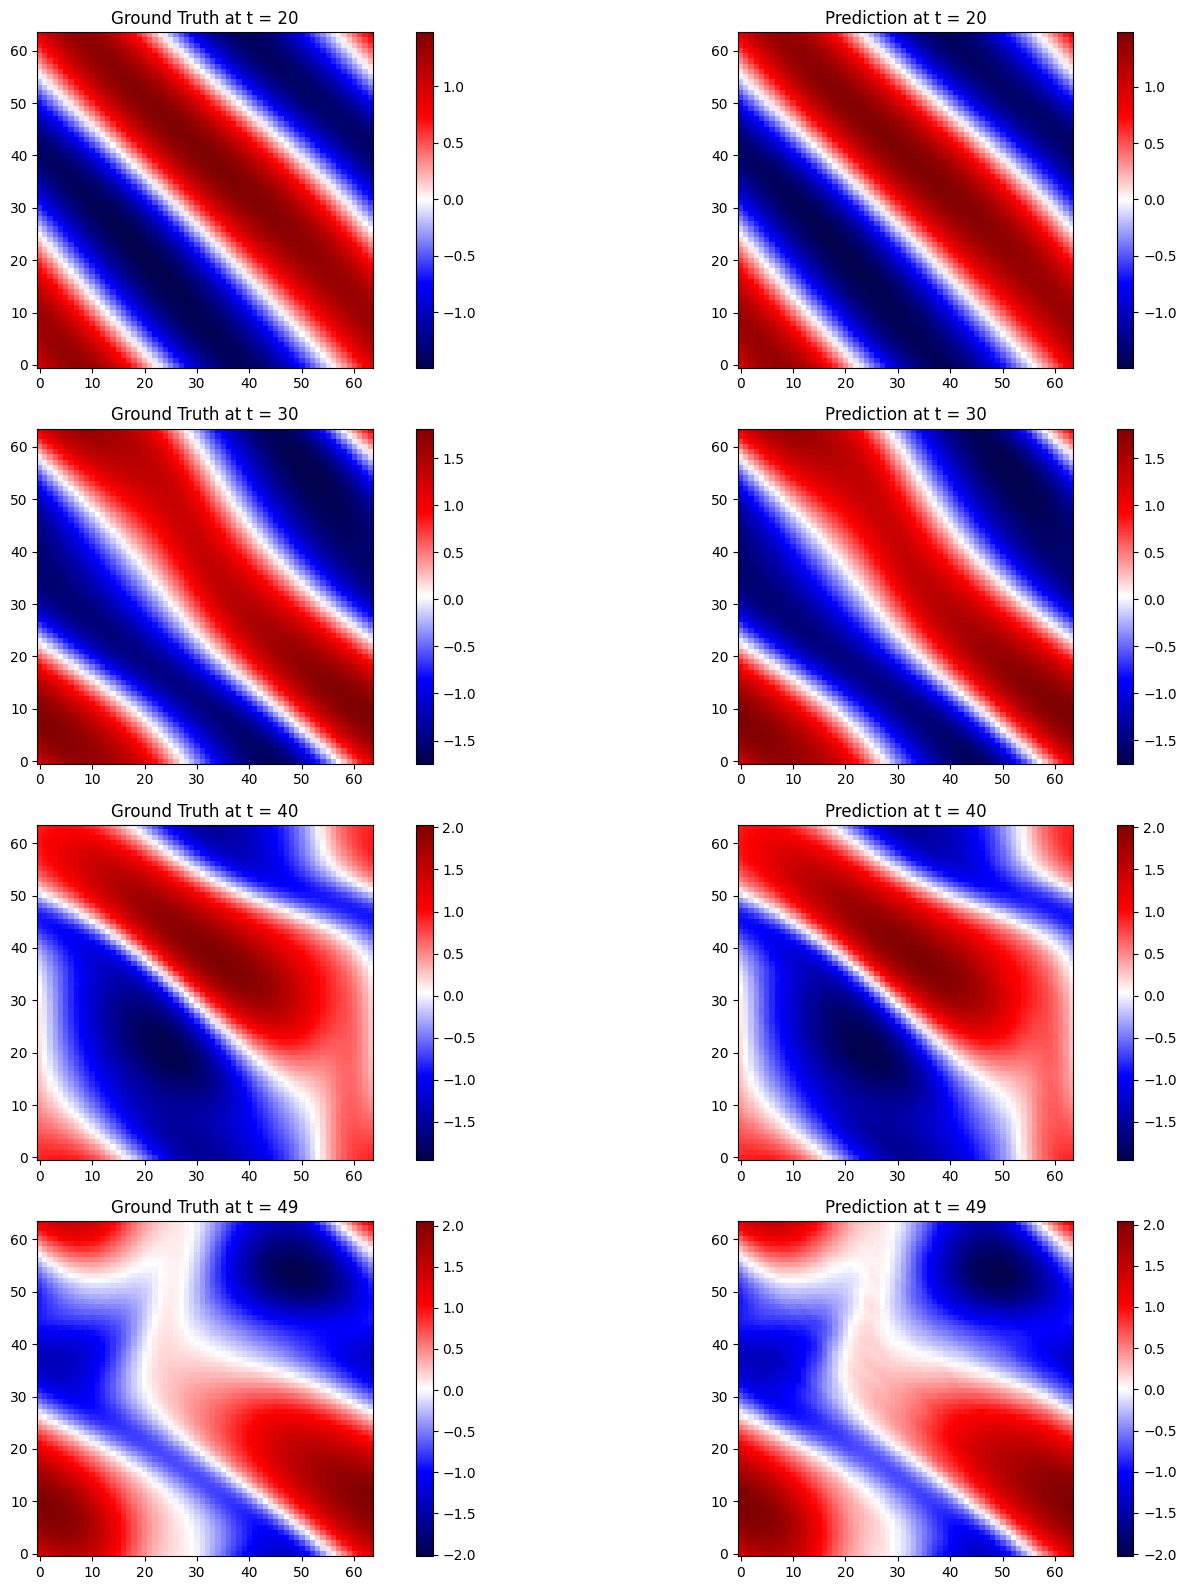

In [4]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# =============================================================================
# 1. Navier–Stokes PDE solver (pseudo-spectral method)
# =============================================================================
def solve_navier_stokes(w0, nu, dt, t_final, N):
    """
    2D Navier–Stokes vorticity PDE (주기적 경계조건)을 푸는 간단한 pseudo-spectral solver.
    
    PDE:
        ∂ₜw + u · ∇w = ν ∆w + f(x)
        u = (ψ_y, -ψ_x),  and  ∆ψ = -w,  with periodic boundary conditions.
    
    입력:
        w0: 초기 vorticity, shape (N, N)
        nu: 점성 계수
        dt: 시간 스텝
        t_final: 최종 시간
        N: 격자 크기 (N×N)
    출력:
        snapshots: 정수 시간마다 (t, w) 튜플 리스트.
    """
    x = np.linspace(0, 1, N, endpoint=False)
    y = np.linspace(0, 1, N, endpoint=False)
    xv, yv = np.meshgrid(x, y, indexing='ij')
    f = 0.1 * (np.sin(2*np.pi*(xv + yv)) + np.cos(2*np.pi*(xv + yv)))
    kx = np.fft.fftfreq(N, d=1.0/N) * 2*np.pi
    ky = np.fft.fftfreq(N, d=1.0/N) * 2*np.pi
    kx, ky = np.meshgrid(kx, ky, indexing='ij')
    ksq = kx**2 + ky**2
    ksq[0,0] = 1.0  # 0분할 방지
    w = w0.copy()
    snapshots = []
    snapshot_times = np.arange(0, t_final+dt, 1.0)
    next_snapshot_index = 0
    nsteps = int(t_final/dt)
    for step in range(nsteps):
        t = step * dt
        if next_snapshot_index < len(snapshot_times) and t >= snapshot_times[next_snapshot_index]:
            snapshots.append((t, w.copy()))
            next_snapshot_index += 1
        w_hat = np.fft.fft2(w)
        psi_hat = -w_hat / ksq
        psi_hat[0,0] = 0.0
        psi = np.real(np.fft.ifft2(psi_hat))
        u = np.real(np.fft.ifft2(1j * ky * psi_hat))
        v = -np.real(np.fft.ifft2(1j * kx * psi_hat))
        w_x = np.real(np.fft.ifft2(1j * kx * w_hat))
        w_y = np.real(np.fft.ifft2(1j * ky * w_hat))
        nonlinear = u * w_x + v * w_y
        lap_w = np.real(np.fft.ifft2(-ksq * w_hat))
        w = w + dt * (-nonlinear + nu * lap_w + f)
    return snapshots

# =============================================================================
# 2. Navier-Stokes 데이터셋 (PDE solver를 사용하여 데이터 생성)
# =============================================================================
class NavierStokesDatasetFromSolver(Dataset):
    def __init__(self, num_samples, N, dt, t_final, nu, T_in_range, T_out_times):
        """
        num_samples: 샘플 개수.
        N: 공간 격자 크기 (N×N).
        dt: 시간 스텝.
        t_final: 최종 시각 (예: 50).
        nu: 점성 계수.
        T_in_range: 입력 시간 구간 (예: (0, 10)).
        T_out_times: 타겟 시간 (예: [15, 20, 25, 30]).
        """
        self.samples = []
        for i in range(num_samples):
            w0 = np.random.randn(N, N)
            snapshots = solve_navier_stokes(w0, nu, dt, t_final, N)
            input_series = []
            for t, w in snapshots:
                if t >= T_in_range[0] and t <= T_in_range[1]:
                    input_series.append(w)
            input_series = np.array(input_series)  # shape: (T_in, N, N)
            target_series = []
            for t, w in snapshots:
                if t in T_out_times:
                    target_series.append(w)
            target_series = np.array(target_series)  # shape: (T_out, N, N)
            self.samples.append((input_series, target_series))
        x = np.linspace(0, 1, N, endpoint=False)
        y = np.linspace(0, 1, N, endpoint=False)
        xv, yv = np.meshgrid(x, y, indexing='ij')
        self.spatial_coords = np.stack([xv, yv], axis=-1)  # (N, N, 2)
        self.input_times = np.arange(T_in_range[0], T_in_range[1]+1)
        self.target_times = np.array(T_out_times)
        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        input_series, target_series = self.samples[idx]
        T_in = input_series.shape[0]
        N = input_series.shape[1]
        input_data = []
        for i, t in enumerate(self.input_times):
            t_field = np.full((N, N, 1), t)
            w_field = input_series[i][:, :, np.newaxis]
            combined = np.concatenate([w_field, t_field, self.spatial_coords], axis=-1)
            input_data.append(combined)
        input_data = np.stack(input_data, axis=0)  # shape: (T_in, N, N, 4)
        if target_series.shape[0] < len(self.target_times):
            pad_len = len(self.target_times) - target_series.shape[0]
            last = target_series[-1:,...]
            pad = np.repeat(last, pad_len, axis=0)
            target_series = np.concatenate([target_series, pad], axis=0)
        target_data = []
        for i in range(target_series.shape[0]):
            target_data.append(target_series[i][:, :, np.newaxis])
        target_data = np.stack(target_data, axis=0)  # shape: (T_out, N, N, 1)
        input_data = torch.tensor(input_data, dtype=torch.float32)
        target_data = torch.tensor(target_data, dtype=torch.float32)
        return input_data, target_data

# =============================================================================
# 3. Linear Attention Block (Memory Efficient)
# =============================================================================
class LinearAttentionBlock(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(LinearAttentionBlock, self).__init__()
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        self.out_proj = nn.Linear(embed_dim, embed_dim)
        self.norm = nn.LayerNorm(embed_dim)
    
    def forward(self, x):
        # x: (B, seq_len, embed_dim)
        B, N, C = x.shape
        # Compute query, key, value projections
        q = self.q_proj(x)  # (B, N, C)
        k = self.k_proj(x)
        v = self.v_proj(x)
        # Reshape for multi-head attention: (B, num_heads, N, head_dim)
        q = q.view(B, N, self.num_heads, self.head_dim).transpose(1, 2)
        k = k.view(B, N, self.num_heads, self.head_dim).transpose(1, 2)
        v = v.view(B, N, self.num_heads, self.head_dim).transpose(1, 2)
        # Apply kernel feature mapping: φ(x) = elu(x)+1
        q = F.elu(q) + 1
        k = F.elu(k) + 1
        # Linear attention: Compute kv = sum_n φ(k_n) v_n^T for each head.
        kv = torch.einsum("bhnd,bhne->bhde", k, v)
        # Compute normalization factor: z = 1 / (φ(q) (sum_n φ(k_n)))
        k_sum = k.sum(dim=2)  # (B, num_heads, head_dim)
        z = torch.einsum("bhnd,bhd->bhn", q, k_sum)  # (B, num_heads, N)
        # Compute attention output: out = φ(q) (kv) / z
        out = torch.einsum("bhnd,bhde->bhne", q, kv)  # (B, num_heads, N, head_dim)
        out = out / (z.unsqueeze(-1) + 1e-6)
        # Reshape back to (B, N, embed_dim)
        out = out.transpose(1, 2).contiguous().view(B, N, C)
        out = self.out_proj(out)
        # Add residual and layer normalization
        out = self.norm(x + out)
        return out

# =============================================================================
# 4. FNO Model with Linear Attention and Physics-Informed Loss
# =============================================================================
class SpectralConv3d(nn.Module):
    def __init__(self, in_channels, out_channels, modes_t, modes_x, modes_y):
        super(SpectralConv3d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes_t = modes_t
        self.modes_x = modes_x
        self.modes_y = modes_y
        self.scale = 1 / (in_channels * out_channels)
        self.weights = nn.Parameter(
            self.scale * torch.rand(in_channels, out_channels, modes_t, modes_x, modes_y, 2)
        )
    
    def compl_mul3d(self, input, weights):
        weight_complex = torch.view_as_complex(weights)
        return torch.einsum("bctxy, cotxy -> botxy", input, weight_complex)
    
    def forward(self, x):
        batchsize = x.shape[0]
        x_ft = torch.fft.rfftn(x, dim=[2,3,4])
        out_ft = torch.zeros(
            batchsize, self.out_channels, x_ft.size(2), x_ft.size(3), x_ft.size(4),
            device=x.device, dtype=torch.cfloat
        )
        t_modes = min(self.modes_t, x_ft.size(2))
        x_modes = min(self.modes_x, x_ft.size(3))
        y_modes = min(self.modes_y, x_ft.size(4))
        out_ft[:, :, :t_modes, :x_modes, :y_modes] = self.compl_mul3d(
            x_ft[:, :, :t_modes, :x_modes, :y_modes],
            self.weights[:, :, :t_modes, :x_modes, :y_modes]
        )
        x = torch.fft.irfftn(out_ft, s=(x.size(2), x.size(3), x.size(4)))
        return x

class FNO3d(nn.Module):
    def __init__(self, modes_t, modes_x, modes_y, width, T_in, T_out, num_heads=4):
        """
        modes_t, modes_x, modes_y: Fourier modes along time and space.
        width: latent channel dimension.
        T_in: number of input time steps (예: 11, t=0~10)
        T_out: number of output time steps (예: 4, t=15,20,25,30)
        num_heads: number of heads for the linear attention block.
        """
        super(FNO3d, self).__init__()
        self.width = width
        self.T_in = T_in
        self.T_out = T_out
        self.fc0 = nn.Linear(4, width)  # 입력: [vorticity, t, x, y]
        
        self.conv0 = SpectralConv3d(width, width, modes_t, modes_x, modes_y)
        self.conv1 = SpectralConv3d(width, width, modes_t, modes_x, modes_y)
        self.conv2 = SpectralConv3d(width, width, modes_t, modes_x, modes_y)
        self.conv3 = SpectralConv3d(width, width, modes_t, modes_x, modes_y)
        
        self.w0 = nn.Conv3d(width, width, 1)
        self.w1 = nn.Conv3d(width, width, 1)
        self.w2 = nn.Conv3d(width, width, 1)
        self.w3 = nn.Conv3d(width, width, 1)
        
        # Apply Linear Attention on the latent features
        self.attn_block = LinearAttentionBlock(embed_dim=width, num_heads=num_heads)
        
        self.fc1 = nn.Linear(width, 128)
        self.fc2 = nn.Linear(128, 1)  # 출력: vorticity
        
        # Temporal predictor: map input time dimension T_in to output time dimension T_out per pixel
        self.temporal_fc = nn.Linear(T_in, T_out)
        
    def forward(self, x):
        # x: (batch, T_in, H, W, 4)
        batch, T_in, H, W, _ = x.shape
        x = self.fc0(x)  # (batch, T_in, H, W, width)
        x = x.permute(0, 4, 1, 2, 3)  # (batch, width, T_in, H, W)
        
        x0 = self.conv0(x)
        x1 = self.w0(x)
        x = F.gelu(x0 + x1)
        
        x0 = self.conv1(x)
        x1 = self.w1(x)
        x = F.gelu(x0 + x1)
        
        x0 = self.conv2(x)
        x1 = self.w2(x)
        x = F.gelu(x0 + x1)
        
        x0 = self.conv3(x)
        x1 = self.w3(x)
        x = F.gelu(x0 + x1)
        
        # Reshape for attention: (batch, T_in, H, W, width) -> (batch, seq_len, width)
        x = x.permute(0, 2, 3, 4, 1)  # (batch, T_in, H, W, width)
        B, T, H, W, C = x.shape
        x_flat = x.view(B, T*H*W, C)  # (batch, seq_len, width)
        
        # Apply linear attention block (memory-efficient)
        x_flat = self.attn_block(x_flat)  # (batch, seq_len, width)
        x = x_flat.view(B, T, H, W, C)  # (batch, T_in, H, W, width)
        
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)  # (batch, T_in, H, W, 1)
        
        # Temporal prediction: map the time dimension from T_in to T_out per pixel
        x = x.squeeze(-1)         # (batch, T_in, H, W)
        x = x.permute(0, 2, 3, 1)   # (batch, H, W, T_in)
        x = self.temporal_fc(x)     # (batch, H, W, T_out)
        x = x.permute(0, 3, 1, 2).unsqueeze(-1)  # (batch, T_out, H, W, 1)
        return x

# =============================================================================
# 4. 학습 루프 및 시각화
# =============================================================================
def train_model_3d(model, train_loader, test_loader, epochs=300):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
    loss_fn = nn.MSELoss()
    train_losses = []
    test_losses = []
    
    for epoch in range(1, epochs+1):
        model.train()
        total_loss = 0.0
        for input_data, target in train_loader:
            input_data = input_data.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            output = model(input_data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * input_data.size(0)
        total_loss /= len(train_loader.dataset)
        train_losses.append(total_loss)
        
        model.eval()
        total_loss_test = 0.0
        with torch.no_grad():
            for input_data, target in test_loader:
                input_data = input_data.to(device)
                target = target.to(device)
                output = model(input_data)
                loss = loss_fn(output, target)
                total_loss_test += loss.item() * input_data.size(0)
        total_loss_test /= len(test_loader.dataset)
        test_losses.append(total_loss_test)
        #scheduler.step()
        print(f"Epoch {epoch:03d}: Train Loss = {total_loss:.6f}, Test Loss = {total_loss_test:.6f}")
    
      
    
    return train_losses, test_losses

def visualize_sample_3d(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    with torch.no_grad():
        input_data, target = next(iter(test_loader))
        input_data = input_data.to(device)
        pred = model(input_data)
    sample_target = target[0].cpu().numpy()  # (T_out, H, W, 1)
    sample_pred = pred[0].cpu().numpy()      # (T_out, H, W, 1)
    times = [20, 30, 40, 49]  # target 시간 라벨
    T_out = sample_target.shape[0]
    plt.figure(figsize=(16, 4*T_out))
    for i in range(T_out):
        plt.subplot(T_out, 2, 2*i+1)
        plt.title(f"Ground Truth at t = {times[i]}")
        plt.imshow(sample_target[i, :, :, 0], cmap="seismic", origin="lower")
        plt.colorbar()
        plt.subplot(T_out, 2, 2*i+2)
        plt.title(f"Prediction at t = {times[i]}")
        plt.imshow(sample_pred[i, :, :, 0], cmap="seismic", origin="lower")
        plt.colorbar()
    plt.tight_layout()
    plt.show()

# =============================================================================
# 5. 전체 파이프라인 실행
# =============================================================================
if __name__ == '__main__':
    # PDE simulation parameters
    N = 64         # spatial resolution: 64x64
    dt = 0.005     # 시간 스텝 (안정성을 위해 충분히 작게)
    t_final = 50   # 최종 시각
    nu = 1e-3      # 점성 계수 (예시)
    
    # 데이터셋에서 사용할 시간 구간
    T_in_range = (0, 10)          # 입력: t=0 ~ 10 (정수 시간 스냅샷)
    T_out_times = [20, 30, 40, 49] # 타겟: t = 20,30,40,49
    
    num_train = 1000   # 샘플 수
    num_test = 200
    
    dataset_solver_train = NavierStokesDatasetFromSolver(num_samples=num_train, N=N, dt=dt, t_final=t_final, nu=nu, 
                                                          T_in_range=T_in_range, T_out_times=T_out_times)
    dataset_solver_test  = NavierStokesDatasetFromSolver(num_samples=num_test, N=N, dt=dt, t_final=t_final, nu=nu, 
                                                          T_in_range=T_in_range, T_out_times=T_out_times)
    
    train_loader = DataLoader(dataset_solver_train, batch_size=2, shuffle=True)
    test_loader = DataLoader(dataset_solver_test, batch_size=2, shuffle=False)
    
    modes_t, modes_x, modes_y = 4, 16, 16
    width = 32
    T_out = len(T_out_times)
    T_in = 11
    model = FNO3d(modes_t, modes_x, modes_y, width, T_in, T_out, num_heads=4)
    
    # 학습
    train_losses, test_losses = train_model_3d(model, train_loader, test_loader, epochs=1000)
    
    # 결과 시각화
    visualize_sample_3d(model, test_loader)



In [ ]:
    # 결과 시각화
visualize_sample_3d(model, test_loader)

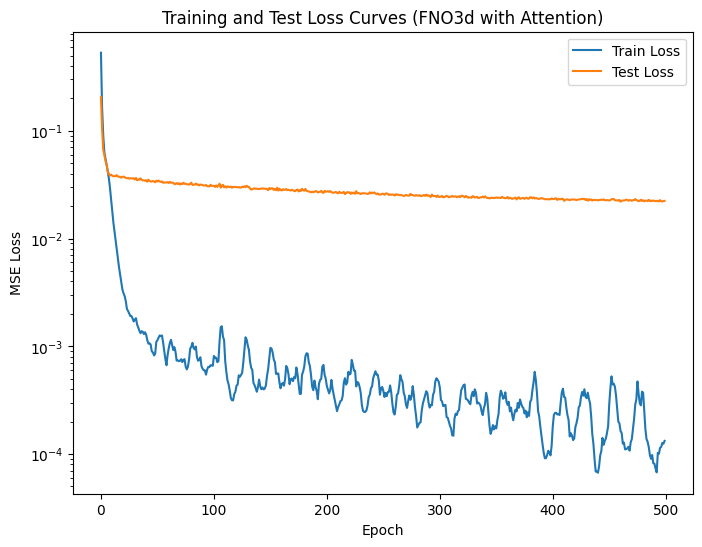

In [2]:
plt.figure(figsize=(8,6))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.yscale('log')
plt.legend()
plt.title("Training and Test Loss Curves (FNO3d with Attention)")
plt.show()